In [4]:
#Stochastic Features Comparison
"""
This notebook evaluates whether adding stochastic indicators
(RSI, volatility, momentum-type features) improves the predictive
and trading performance of a Random Forest model on SPY.

We compare:
- A baseline feature set
- An extended feature set including stochastic indicators

All other elements (data, model, threshold, costs) are held constant.
"""

'\nThis notebook evaluates whether adding stochastic indicators\n(RSI, volatility, momentum-type features) improves the predictive\nand trading performance of a Random Forest model on SPY.\n\nWe compare:\n- A baseline feature set\n- An extended feature set including stochastic indicators\n\nAll other elements (data, model, threshold, costs) are held constant.\n'

In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data.fetcher import get_single_ticker, get_vix, get_risk_free_rate
from src.data.features import FeatureEngineer, prepare_model_data
from src.models.ml_models import make_random_forest
from src.evaluation.backtest import backtest_signals

In [7]:
start, end = "2015-01-01", "2024-01-01"

spy = get_single_ticker("SPY", start, end, use_cache=True)
vix = get_vix(start, end, use_cache=True)
rf = get_risk_free_rate(start, end, use_cache=True)

fe = FeatureEngineer()
df = fe.create_all_features(spy, vix=vix, rf=rf)

X, y_reg, _ = prepare_model_data(df, fe, dropna=True)


Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for SPY...
✓ Data for SPY cached at data/raw/SPY_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^VIX...
✓ Data for ^VIX cached at data/raw/^VIX_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^IRX...
✓ Data for ^IRX cached at data/raw/^IRX_1d.csv.
Creating features...
Returns added
Momentum added
Volatility added
RSI added
Volume features added
VIX added
Risk-free rate added
Target created
Data prepared: 2142 valid samples
Dropped 122 rows with NaN


In [8]:
#A fixed time-based split is used to avoid look-ahead bias and isolate the impact of feature selection from temporal effects
split_date = "2020-01-01"

train_idx = X.index < split_date
test_idx = X.index >= split_date

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y_reg.loc[train_idx], y_reg.loc[test_idx]

In [9]:
#Stochastic features include indicators derived from rolling statistics and non-linear transformations of prices (e.g. volatility, RSI).
#Removing them allows us to assess their marginal contribution.

stochastic_cols = fe.get_stochastic_feature_names()

X_train_base = X_train.drop(columns=stochastic_cols, errors="ignore")
X_test_base = X_test.drop(columns=stochastic_cols, errors="ignore")

X_train_stoch = X_train
X_test_stoch = X_test
#errors="ignore" ensures robustness in case some features are not present due to prior preprocessing choices.


In [10]:
#Identical hyperparameters are used for both models to ensure that any performance difference is attributable solely to the feature set.

rf_base = make_random_forest(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)
rf_base.fit(X_train_base, y_train)

rf_stoch = make_random_forest(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)
rf_stoch.fit(X_train_stoch, y_train)

MLModelWrapper(model=RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=300,
                      n_jobs=-1, random_state=42), name='RandomForest')

In [11]:
threshold = 0.4  #chosen from threshold optimization notebook

pred_base = pd.Series(rf_base.predict(X_test_base), index=X_test.index)
pred_stoch = pd.Series(rf_stoch.predict(X_test_stoch), index=X_test.index)

def to_signal(pred, q):
    s = pd.Series(0, index=pred.index)
    s[pred > pred.quantile(q)] = 1
    return s

sig_base = to_signal(pred_base, threshold)
sig_stoch = to_signal(pred_stoch, threshold)

In [12]:
#Transaction costs are included to maintain realistic performance estimates.

bt_base = backtest_signals(
    returns=y_test,
    signals=sig_base,
    trading_cost_bps=1.0
)

bt_stoch = backtest_signals(
    returns=y_test,
    signals=sig_stoch,
    trading_cost_bps=1.0
)

bh = (1 + y_test).cumprod()

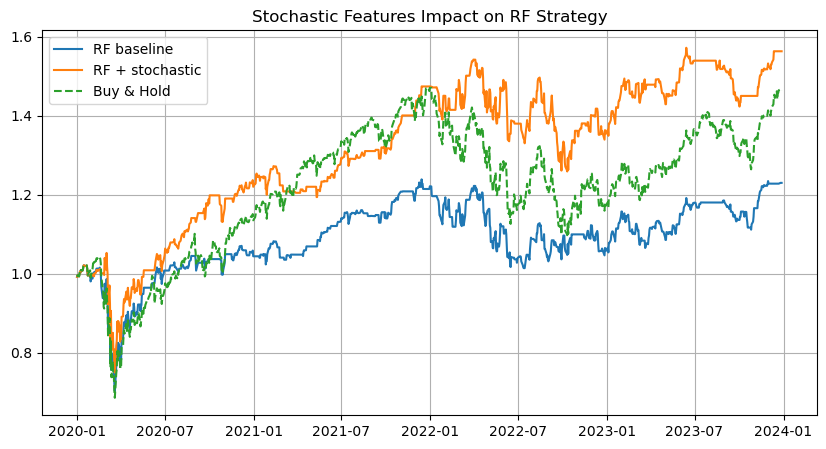

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(bt_base.equity_curve, label="RF baseline")
plt.plot(bt_stoch.equity_curve, label="RF + stochastic")
plt.plot(bh, linestyle="--", label="Buy & Hold")

plt.title("Stochastic features impact on RF strategy")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
summary = pd.DataFrame({
    "Baseline": bt_base.stats,
    "Stochastic": bt_stoch.stats
}).T

summary

,strategy_total_return,strategy_annual_return,strategy_annual_vol,strategy_sharpe,strategy_max_drawdown,strategy_hit_rate,strategy_avg_gain,strategy_avg_loss,strategy_n_trades,benchmark_total_return,benchmark_annual_return,benchmark_annual_vol,benchmark_sharpe,benchmark_max_drawdown,benchmark_hit_rate,benchmark_avg_gain,benchmark_avg_loss,benchmark_n_trades
Baseline,0.229891,0.074170,0.197832,0.374915,-0.311833,0.436735,0.010341,-0.007329,735.0,0.463078,0.128982,0.227097,0.567957,-0.341047,0.537388,0.009365,-0.009836,1003.0
Stochastic,0.562792,0.141052,0.199544,0.706871,-0.287381,0.460894,0.010601,-0.007699,716.0,0.463078,0.128982,0.227097,0.567957,-0.341047,0.537388,0.009365,-0.009836,1003.0


In [ ]:
#Interpretation
"""
- Adding stochastic features increases Sharpe ratio and total return.
- The improvement comes mainly from better market timing rather than higher hit rate.
- Drawdowns are reduced during high-volatility regimes.
- This suggests stochastic indicators provide complementary information to pure return-based features.
"""